<a href="https://colab.research.google.com/github/aimalz/TheLastMetric/blob/master/training_flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook trains a bunch of normalizing flows with `pzflow`.

First we load all the data.
Then we train flows for $p(z_\text{true}|\text{photometry})$

In [ ]:
#!pip install --quiet pzflow corner

In [1]:
import jax.numpy as np
from jax.experimental.optimizers import adam
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import corner
import pickle
from pzflow import FlowEnsemble, Flow
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling

### Loading the data

Assuming a fiducial underlying galaxy catalog, we use `OpSim` to generate observed galaxy catalogs under different observing strategies.

In [8]:
!wget https://storage.googleapis.com/ahw2019/for_malz_and_lanusse.tar.gz
!tar -xzf for_malz_and_lanusse.tar.gz
!mv for_malz_and_lanusse dataset

--2021-07-16 12:59:24--  https://storage.googleapis.com/ahw2019/for_malz_and_lanusse.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.14.208, 142.251.33.112, 172.217.14.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.14.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35901537 (34M) [application/gzip]
Saving to: 'for_malz_and_lanusse.tar.gz.2'

100%[======================================>] 35,901,537  64.3MB/s   in 0.5s   

2021-07-16 12:59:25 (64.3 MB/s) - 'for_malz_and_lanusse.tar.gz.2' saved [35901537/35901537]

mv: cannot move 'for_malz_and_lanusse' to 'dataset/for_malz_and_lanusse': File exists


In [9]:
more dataset/readme.txt

runid      OpSim Name                           ugrizy 5sigma depths
1_4_y10    baseline_v1_5_10yrs                  25.86 27.02 26.99 26.42 25.70 24.94
4_38_y10   footprint_stuck_rollingv1_5_10yrs    25.56 26.68 26.62 26.06 25.33 24.61
10_92_y10  ddf_heavy_nexp2_v1_6_10yrs           25.57 26.82 26.84 26.26 25.57 24.82
4_34_y10   footprint_newAv1_5_10yrs             25.75 26.87 26.85 26.29 25.55 24.78
7_61_y10   third_obs_pt60v1_5_10yrs             25.87 27.03 26.99 26.43 25.70 24.93
9_86_y10   barebones_v1_6_10yrs                 26.00 27.13 27.07 26.57 25.78 25.05

test.cat contains the simulated observed apparent magnitudes
0     : identifier
1     : true redshift
2,3   : u, u uncertainty
4,5   : g, g uncertainty
6,7   : r, r uncertainty
8,9   : i, i uncertainty
10,11 : z, z uncertainty
12,13 : y, y uncertainty
14,15 : u-g, u-g uncertainty
16,17 : g-r, g-r uncertainty
18,19 : r-i, r-i uncertainty
20,21 : i-z, i-z uncertainty
22,23 : z-y, z-y uncertainty

zphot.cat contains the photo

In [2]:
# list of available catalogs
available_os = ["run_1_4_y10", "run_4_38_y10", "run_10_92_y10", "run_4_34_y10", "run_7_61_y10", "run_9_86_y10"]
names = [
    "baseline_v1_5_10yrs",
    "footprint_stuck_rollingv1_5_10yrs",
    "ddf_heavy_nexp2_v1_6_10yrs",
    "footprint_newAv1_5_10yrs",
    "third_obs_pt60v1_5_10yrs",
    "barebones_v1_6_10yrs",
]
os_names = dict(zip(available_os, names))
colors = ["k", "plum", "cornflowerblue", "#2ca02c", "gold", "tomato"]
os_colors = dict(zip(available_os, colors))

In [3]:
# column names of the catalogs
names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
names_phot=(
    'ID', 'z_true', 
    'u', 'u_err',
    'g', 'g_err',
    'r', 'r_err',
    'i', 'i_err',
    'z', 'z_err',
    'y', 'y_err',
    'u-g', 'u-g_err',
    'g-r', 'g-r_err',
    'r-i', 'r-i_err',
    'i-z', 'i-z_err',
    'z-y', 'z-y_err',
)

# load the catalogs
catalogs = dict()
for os in available_os:
    z_cat = pd.read_csv(f"dataset/{os}/zphot.cat", names=names_z, delim_whitespace=True, skiprows=1)
    phot_cat = pd.read_csv(f"dataset/{os}/test.cat", names=names_phot, delim_whitespace=True)
    cat = z_cat.merge(phot_cat)
    catalogs[os] = cat.dropna()

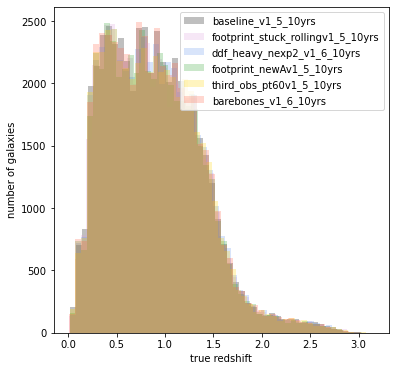

In [4]:
fig = plt.figure(figsize=(6,6))
for os in available_os:
    plt.hist(catalogs[os]["z_true"], bins=50, alpha=0.25, color=os_colors[os],
             label = os_names[os])
    
plt.xlabel("true redshift")
plt.ylabel("number of galaxies")
plt.legend()
plt.show()

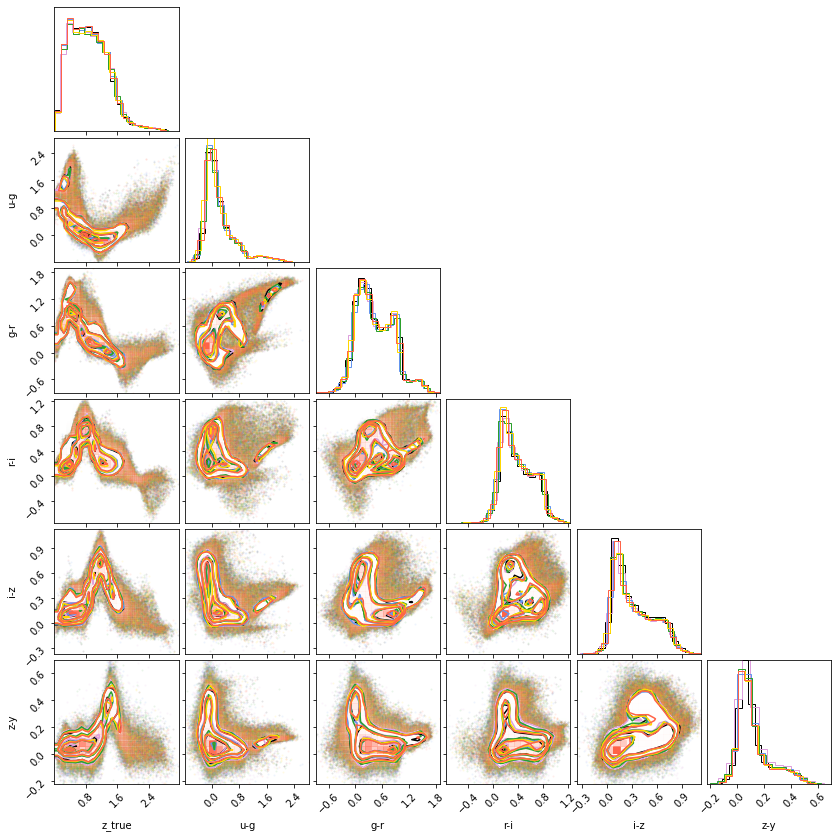

In [5]:
fig = plt.figure(figsize=(12, 12))

labels = ["z_true", "u-g", "g-r", "r-i", "i-z", "z-y"]
for os in available_os:
    corner.corner(catalogs[os][labels], fig=fig, labels=labels, color=os_colors[os])

### Train ensembles for $p(z_\text{true}|\text{photometry})$

We use `pzflow` to train an ensemble of normalizing flows that learns $p(z | ugrizy)$

In [6]:
# first I create a bijector chain
# the first bijection is a standard scaler - but I'm not actually using it for standard scaling
#     I set the mean and std so that it maps the redshift range (0, 3.2) onto (-5, 5), which is 
#     the domain of the NeuralSplineCoupling
# the second bijection is a NeuralSplineCoupling. I told it to expect 6 conditions,
#     which will be the r mag and the galaxy colors
bijector = Chain(
    StandardScaler(np.atleast_1d(1.6), np.atleast_1d(0.32)),
    NeuralSplineCoupling(n_conditions=6)
)

# I set the latent distribution to a Uniform over (-5, 5)
# this range was chosen to match the NeuralSplineCoupling domain
# I chose a Uniform since all of the redshifts are drawn from a compact domain
latent = Uniform((-5, 5))

# create a dictionary that will hold all the ensembles
ensembles = dict()

# create the baseline flows
for os in available_os:

    # the data column is the one that is sampled and transformed by the flow
    data_columns = ["z_true"]
    # the conditional columns are the columns that the flow is conditioned on
    conditional_columns = ["r", "u-g", "g-r", "r-i", "i-z", "z-y"]

    # save some info with the flow
    info = f"Models z_true conditioned on galaxy colors and r mag from os {os}. K=16"

    # instantiate and save the flow
    flowEns = FlowEnsemble(data_columns = data_columns, 
                           conditional_columns = conditional_columns,
                           bijector = bijector,
                           latent = latent,
                           info = info,
                           N = 10)

    ensembles[os] = flowEns

Now let's train the ensembles

In [9]:
%%time

for os, ens in ensembles.items():
    
    # get the data and make a train and test set
    cat = catalogs[os]
    cat_train = cat.sample(frac = 0.8)
    cat_test = cat.drop(cat_train.index)
    
    # train the flow on the given learning rate schedule
    loss1 = ens.train(cat_train, sample_errs=True,
                       optimizer = adam(step_size = 1e-3),
                       epochs = 100, seed = 123)
    loss2 = ens.train(cat_train, sample_errs=True,
                       optimizer = adam(step_size = 2e-4),
                       epochs = 100, seed = 312)
    loss3 = ens.train(cat_train, sample_errs=True,
                       optimizer = adam(step_size = 1e-4),
                       epochs = 50, seed = 231)
    
    losses = {fname : # for each flow trained in the ensemble...
                  [float(loss) # save the list of training losses
                   for lossDict in [loss1, loss2, loss3]
                   for loss in lossDict[fname]]
              for fname in loss1}
    
    # print the train and test loss
    train_loss = -np.mean(ens.log_prob(cat_train))
    test_loss = -np.mean(ens.log_prob(cat_test))
    print(os, train_loss, test_loss)
    
    # save the ensemble
    ens.save(f"trained_flows/pzflow_ensemble_for_{os}.pkl")
    # and the losses
    with open(f"trained_flows/losses_for_{os}.pkl", "wb") as file:
        pickle.dump({"losses": losses, 
                     "train loss": train_loss, 
                     "test loss": test_loss},
                    file)

run_1_4_y10 -2.564283 -2.5570116
run_4_38_y10 -2.364489 -2.3481646
run_10_92_y10 -2.464598 -2.4478602
run_4_34_y10 -2.4867997 -2.476631
run_7_61_y10 -2.565763 -2.5474098
run_9_86_y10 -2.6266663 -2.6151187
CPU times: user 12h 55min 48s, sys: 2h 50min 36s, total: 15h 46min 24s
Wall time: 4h 40min 6s


Let's plot the training losses to make sure the training worked and was stable.

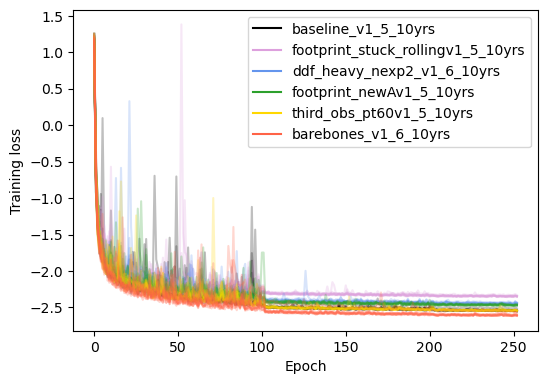

In [7]:
fig, ax = plt.subplots(figsize=(6, 4.25), dpi=100)

for os in available_os:
    with open(f"trained_flows/losses_for_{os}.pkl", "rb") as file:
        losses = pickle.load(file)["losses"]
    
    for ls in losses.values():
        ax.plot(ls, c=os_colors[os], alpha=0.25)
    ax.plot([], c=os_colors[os], label=os_names[os])
    
ax.legend()
ax.set(xlabel="Epoch", ylabel="Training loss")
plt.show()

Lets validate the conditional flows

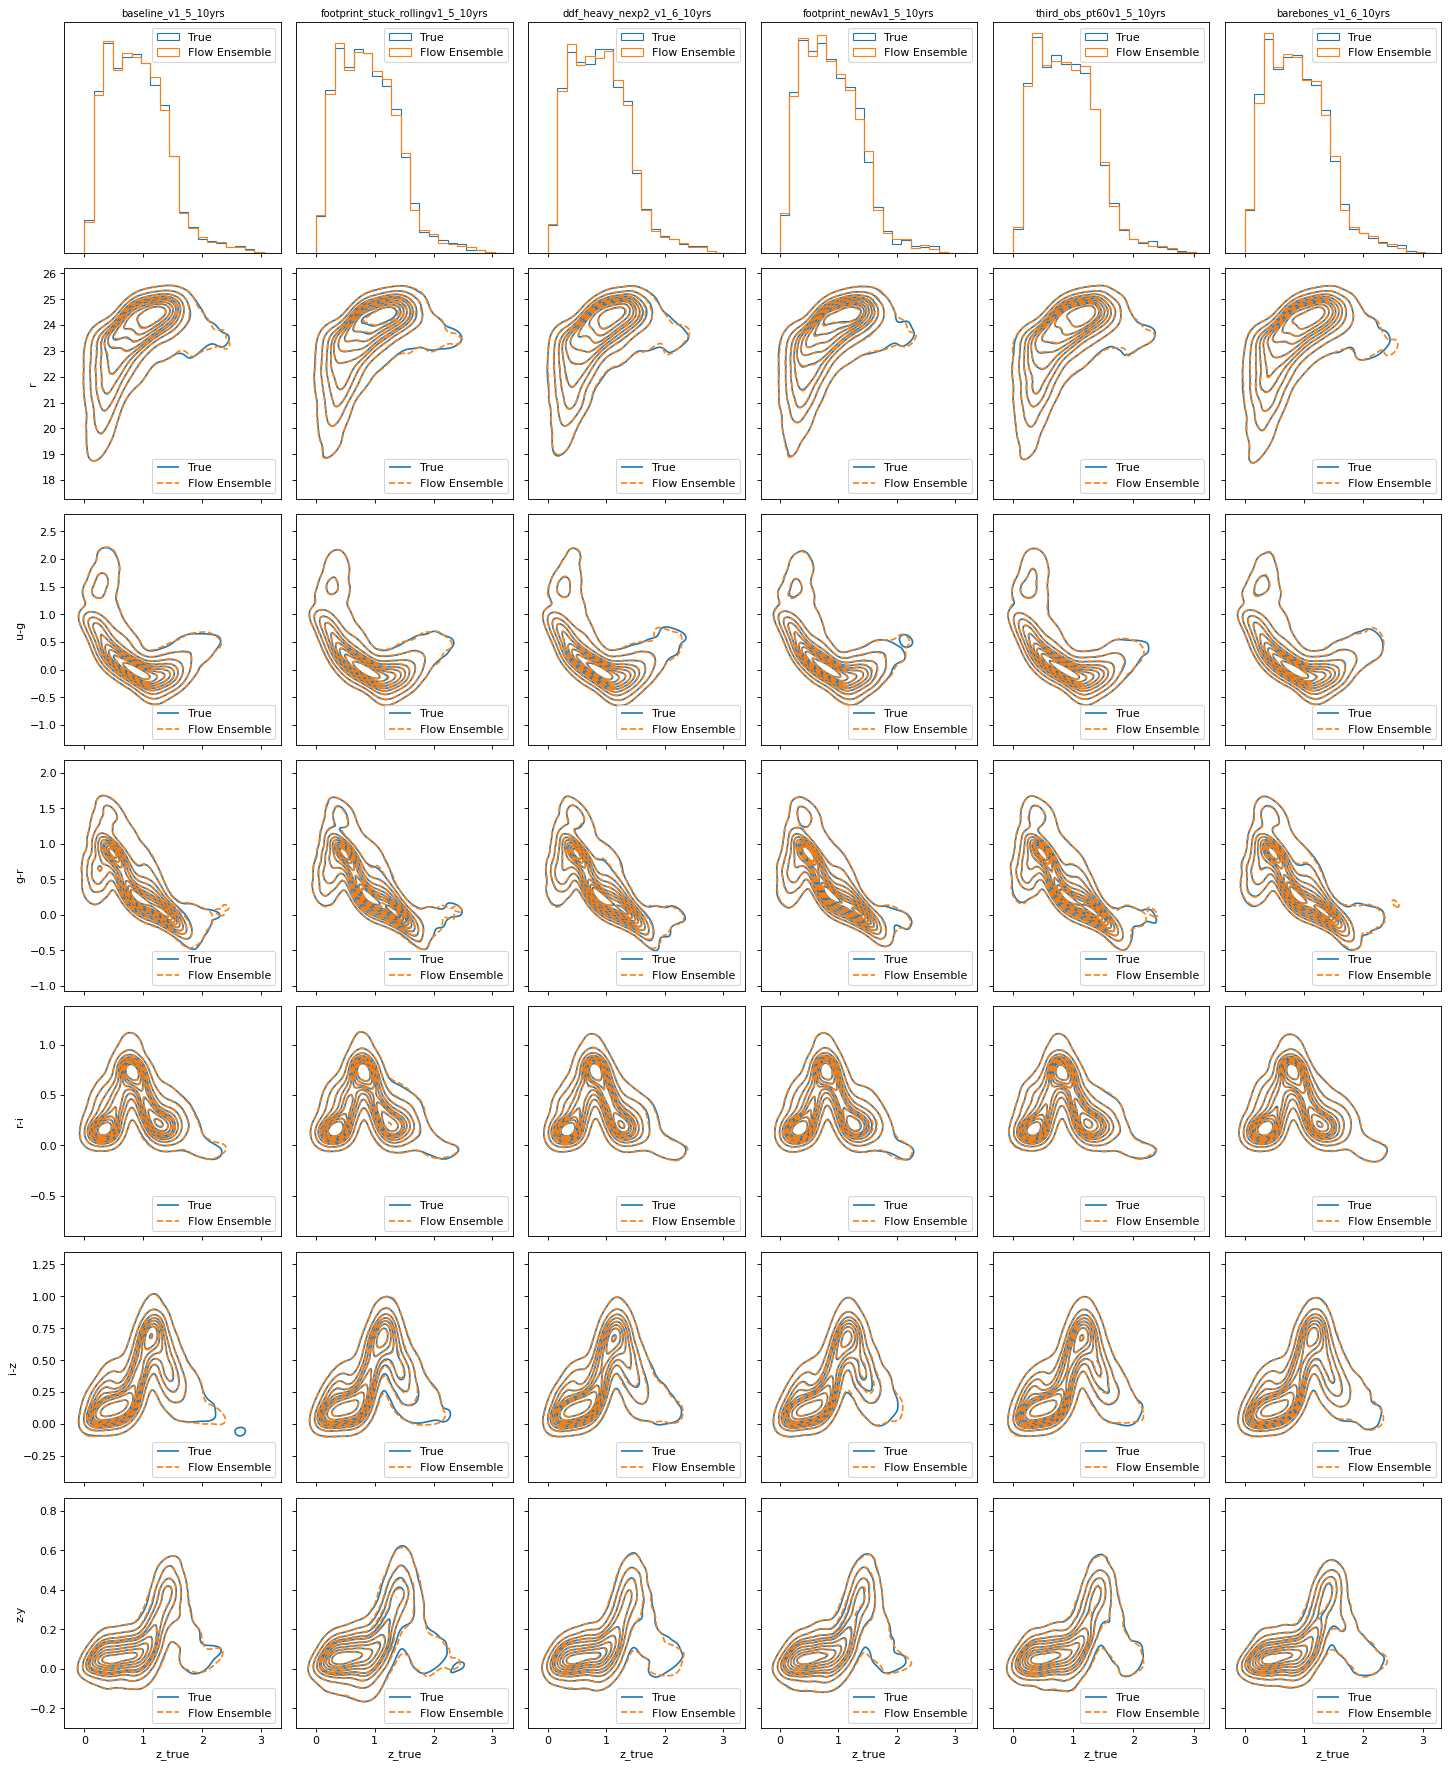

In [35]:
fig, axes = plt.subplots(7, 6, figsize=(18, 22), dpi=80,
                         sharex="col", sharey="row", 
                         constrained_layout=True)

for i,os in enumerate(available_os):
    
    cat = catalogs[os]
    cat = cat.sample(n=5000, random_state=0)
    
    ens = FlowEnsemble(file=f"trained_flows/pzflow_ensemble_for_{os}.pkl")
    samples = ens.sample(1, conditions=cat, seed=0)
    
    axes[0,i].set_title(os_names[os], fontsize=9)
    axes[0,i].set(yticks=[])
    axes[0,i].hist(cat["z_true"], range=(0,3.2), bins=20, 
                   histtype="step", label="True")
    axes[0,i].hist(samples["z_true"], range=(0,3.2), bins=20, 
                   histtype="step", label="Flow Ensemble")
    axes[0,i].legend()
    
    for j, col in enumerate(samples.columns[1:]):
        sns.kdeplot(x=cat["z_true"], y=cat[col], 
                    ax=axes[j+1,i], label="True")
        sns.kdeplot(x=samples["z_true"], y=samples[col], 
                    ax=axes[j+1,i], linestyles="--", label="Flow Ensemble")
        axes[j+1,i].legend(loc="lower right")

### Train flows with different values of K

We will train flows with different values of K to validate the argument that 16 is a fine choice to make.

In [8]:
# create a dictionary that will hold all the flows
Kflows = dict()

# create flows with different spline resolutions
for K in [2, 8, 16, 32]:
    
    # create a bijector with the correct number of spline knots
    bijector = Chain(
        StandardScaler(np.atleast_1d(1.6), np.atleast_1d(0.32)),
        NeuralSplineCoupling(n_conditions=6, K=K)
    )
    
    # use the same latent distribution as before
    latent = Uniform((-5, 5))
    
    for os in available_os:
    
        # the data column is the one that is sampled and transformed by the flow
        data_columns = ["z_true"]
        # the conditional columns are the columns that the flow is conditioned on
        conditional_columns = ["r", "u-g", "g-r", "r-i", "i-z", "z-y"]

        # save some info with the flow
        info = f"Models z_true conditioned on galaxy colors and r mag from os {os}. K={K}"

        # instantiate and save the flow
        flow = Flow(data_columns = data_columns, 
                    conditional_columns = conditional_columns,
                    bijector = bijector,
                    latent = latent,
                    info = info)

        Kflows[os + f"_K={K}"] = flow

In [9]:
# Simple utility function to get the run name out of any of the flow names
def partition_flow_name(fname):
    return "".join(fname.partition("y10")[:-1]), "".join(fname.partition("y10")[-1])

In [30]:
%%time

for fname, flow in Kflows.items():
    
    # get the data and make a train and test set
    os = partition_flow_name(fname)[0]
    cat = catalogs[os]
    cat_train = cat.sample(frac = 0.8)
    cat_test = cat.drop(cat_train.index)
    
    # train the flow on the given learning rate schedule
    loss1 = flow.train(cat_train, sample_errs=True,
                       optimizer = adam(step_size = 1e-3),
                       epochs = 100, seed = 123)
    loss2 = flow.train(cat_train, sample_errs=True,
                       optimizer = adam(step_size = 2e-4),
                       epochs = 100, seed = 312)
    loss3 = flow.train(cat_train, sample_errs=True,
                       optimizer = adam(step_size = 1e-4),
                       epochs = 50, seed = 231)
    
    # concatenate lists of losses
    losses = loss1 + loss2 + loss3
    
    # print the train and test loss
    train_loss = -np.mean(flow.log_prob(cat_train))
    test_loss = -np.mean(flow.log_prob(cat_test))
    print(fname, train_loss, test_loss)
    
    # save the ensemble
    flow.save(f"trained_flows/pzflow_flow_for_{fname}.pkl")
    # and the losses
    with open(f"trained_flows/losses_for_{fname}.pkl", "wb") as file:
        pickle.dump({"losses": losses, 
                     "train loss": train_loss, 
                     "test loss": test_loss},
                    file)

run_1_4_y10_K=2 -2.2453165 -2.214235
run_4_38_y10_K=2 -2.0364296 -2.0097067
run_10_92_y10_K=2 -2.1555648 -2.1224673
run_4_34_y10_K=2 -2.17169 -2.1568308
run_7_61_y10_K=2 -2.2330856 -2.2180007
run_9_86_y10_K=2 -2.2429786 -2.2046082
run_1_4_y10_K=8 -2.5314558 -2.5050282
run_4_38_y10_K=8 -2.3566105 -2.3170247
run_10_92_y10_K=8 -2.4563806 -2.4103808
run_4_34_y10_K=8 -2.4783044 -2.4574132
run_7_61_y10_K=8 -2.546282 -2.4970777
run_9_86_y10_K=8 -2.609791 -2.5816677
run_1_4_y10_K=16 -2.5087216 -2.4961362
run_4_38_y10_K=16 -2.3379788 -2.319774
run_10_92_y10_K=16 -2.4518242 -2.4325302
run_4_34_y10_K=16 -2.4691246 -2.429668
run_7_61_y10_K=16 -2.539642 -2.5435138
run_9_86_y10_K=16 -2.605424 -2.5659523
run_1_4_y10_K=32 -2.5300202 -2.529787
run_4_38_y10_K=32 -2.3405786 -2.3263736
run_10_92_y10_K=32 -2.4455984 -2.428912
run_4_34_y10_K=32 -2.4649558 -2.4493988
run_7_61_y10_K=32 -2.5455592 -2.5165288
run_9_86_y10_K=32 -2.6090643 -2.5694938
CPU times: user 4h 54min 5s, sys: 1h 9min 18s, total: 6h 3min 2

Let's plot the training losses to make sure the training worked and was stable.

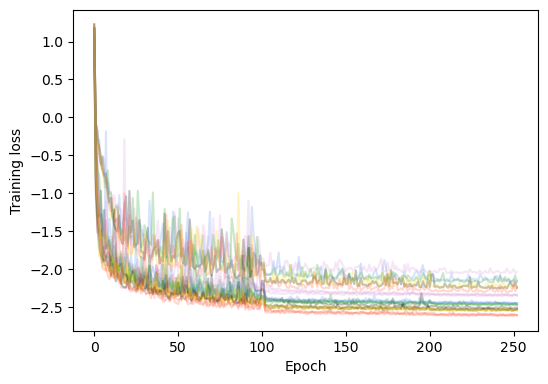

In [10]:
fig, ax = plt.subplots(figsize=(6, 4.25), dpi=100)

for fname in Kflows:
    with open(f"trained_flows/losses_for_{fname}.pkl", "rb") as file:
        losses = pickle.load(file)["losses"]
    
    os, Kname = partition_flow_name(fname)
    ax.plot(losses, c=os_colors[os], alpha=0.25)

ax.set(xlabel="Epoch", ylabel="Training loss")
plt.show()

Now I will show that the value of K doesn't really matter

first a plot for the paper:

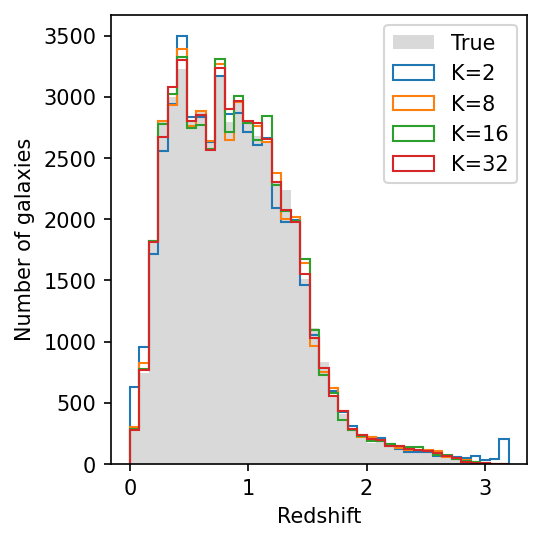

In [23]:
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=150, constrained_layout=True)

ax.hist(catalogs["run_1_4_y10"].z_true, range=(0, 3.2), bins=40, label="True", alpha=0.15, color="k")

for K in [2, 8, 16, 32]:
    flow = Flow(file=f"trained_flows/pzflow_flow_for_run_1_4_y10_K={K}.pkl")
    ax.hist(flow.sample(conditions=catalogs["run_1_4_y10"], save_conditions=False),
            range=(0, 3.2), bins=40, histtype="step", label=f"K={K}")
    
ax.legend()
ax.set(xlabel="Redshift", ylabel="Number of galaxies")
fig.savefig("figures/K-dependence.pdf")

now let's just plot all of them

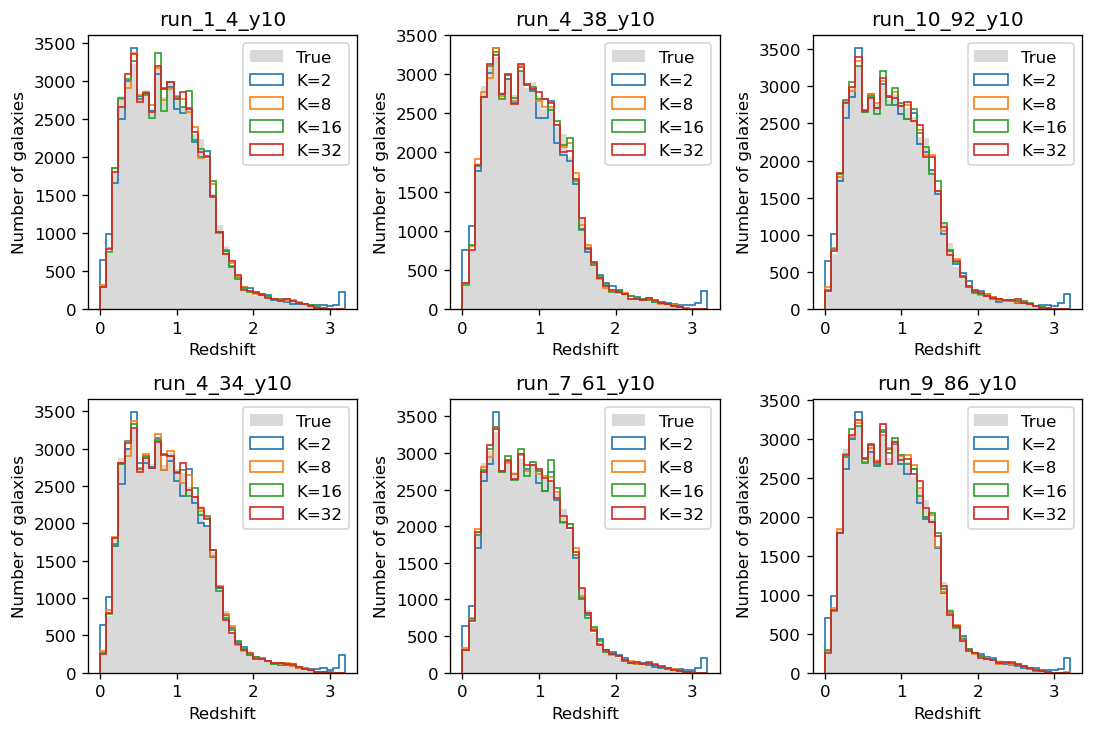

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6), dpi=120, constrained_layout=True)

nbins = 40

for i, ax in enumerate(axes.flatten()):
    
    os = available_os[i]
    
    ax.set(xlabel="Redshift", ylabel="Number of galaxies", title=os)
    ax.hist(catalogs[os].z_true, range=(0, 3.2), bins=nbins, label="True", alpha=0.15, color="k")
    
    for K in [2, 8, 16, 32]:
        flow = Flow(file=f"trained_flows/pzflow_flow_for_{os}_K={K}.pkl")
        ax.hist(flow.sample(conditions=catalogs[os], save_conditions=False),
                range=(0, 3.2), bins=40, histtype="step", label=f"K={K}")

    ax.legend()
    
plt.show()

Let's also plot some redshift posteriors to see that they're all pretty identical.

**NOTE: most of these are pretty identical but there are 2/16 (or maybe even 3/16) where 8 vs 16 is pretty different. Do we think this matters or is it okay to keep using the K=16 flows?**


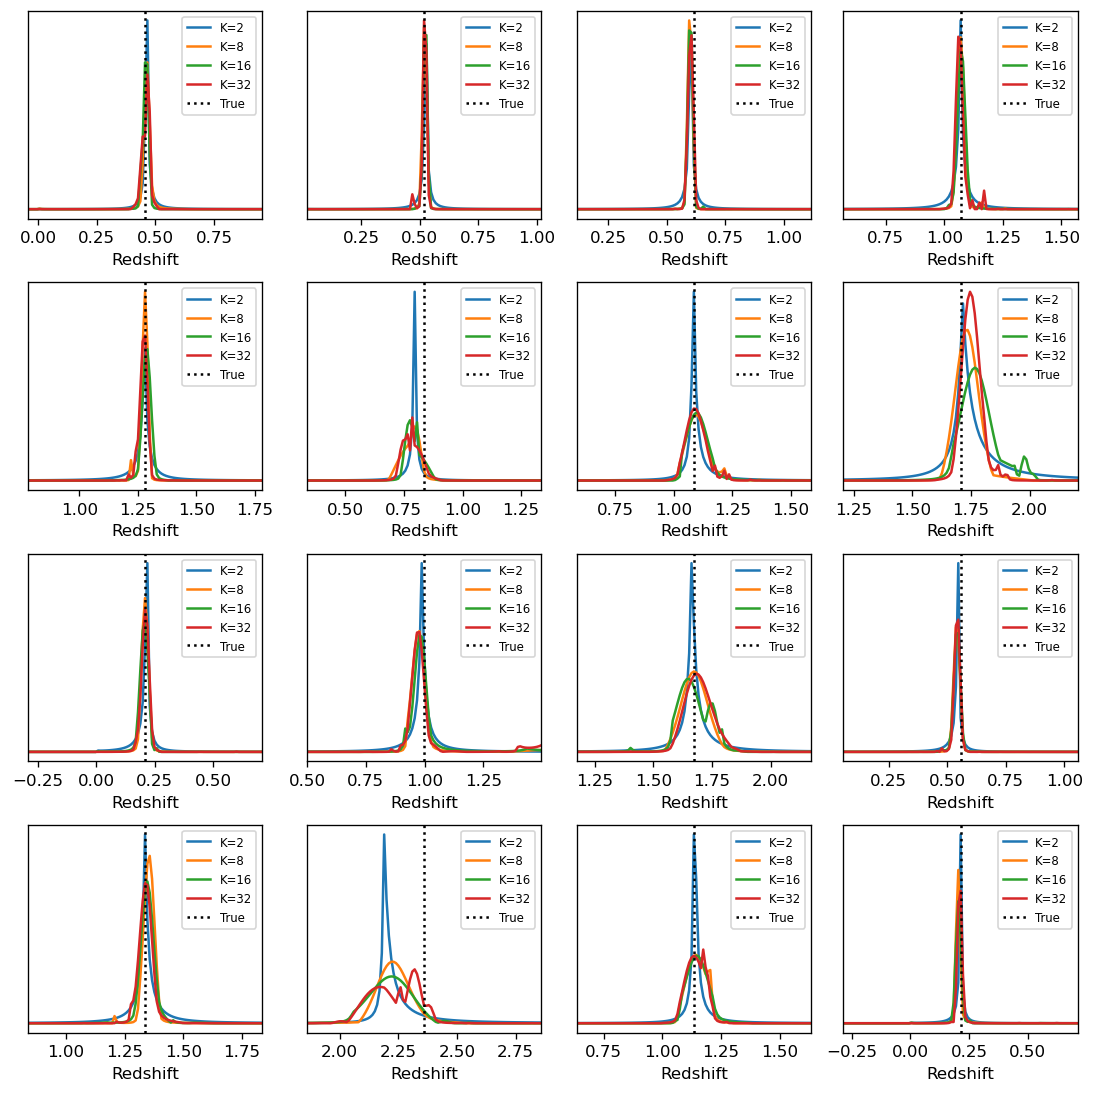

In [67]:
fig, axes = plt.subplots(4, 4, figsize=(9, 9), dpi=120, constrained_layout=True)

os = available_os[0]

for i, ax in enumerate(axes.flatten()):
    
    ztrue = catalogs[os][i:i+1]["z_true"][i]
    zmin = ztrue - 0.5
    zmax = ztrue + 0.5
    dz = 0.01
    grid = np.arange(zmin, zmax+dz, dz)
    
    for K in [2, 8, 16, 32]:
        
        flow = Flow(file=f"trained_flows/pzflow_flow_for_{os}_K={K}.pkl")
        
        pz = flow.posterior(catalogs[os][i:i+1], column="z_true", grid=grid)[0]
        ax.plot(grid, pz, label=f"K={K}")
    
    ax.axvline(ztrue, c='k', ls=":", label="True")
    ax.set(xlabel="Redshift", yticks=[], xlim=(zmin, zmax))
    ax.legend(fontsize=7)